In [2]:
from importlib import reload
import pandas as pd
import pickle
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

In [7]:
alphabet = list(pickle.load(open('data/alphabet.pkl', 'rb')))
len(alphabet)

36

In [12]:
df = pd.read_json('data/persian-tts-train.json', lines=True, orient='records')
df.head()

,text,duration,path
0,اما انها از خدا روی گردان شدند و ما سیل ویرانگ...,21.838367,/home/soroosh/data/tts/wavs/034016.wav
1,و کسانی که ایمان اوردند و کارهای شایسته انجام ...,29.309388,/home/soroosh/data/tts/wavs/004057.wav
2,یا اینکه مالکیت و حاکمیت اسمانها و زمین و انچه...,21.002449,/home/soroosh/data/tts/wavs/038010.wav
3,ولی کافران پیوسته در تکذیب حقند,4.388571,/home/soroosh/data/tts/wavs/085019.wav
4,و از انها مباش که ایات خدا را تکذیب کردند که ا...,7.209796,/home/soroosh/data/tts/wavs/010095.wav


In [13]:
df['sentence'] = df['text']
df.drop(['text'], axis=1, inplace=True)

In [14]:
df.to_json('data/persian-tts-train.json', lines=True, orient='records')

In [12]:
import tacotron_tts.text_processor
reload(tacotron_tts.text_processor)
from tacotron_tts.text_processor import TextProcessor

text_processor = TextProcessor(alphabet)

In [14]:
print(text_processor(df['sentence'][0], to_phones=False, to_indices=True))

[36, 12, 19, 12, 32, 19, 21, 17, 19, 33, 15, 7, 19, 20, 17, 19, 8, 7, 19, 27, 1, 37]


In [77]:
import tacotron_tts.audio_processor
reload(tacotron_tts.audio_processor)
from tacotron_tts.audio_processor import AudioProcessor

audio_processor = AudioProcessor(
    sr=22050, ref_level_db=20, n_fft=2048, n_mels=80, hop_length=1024, window='hann'
)

(80, 62) (1025, 62)


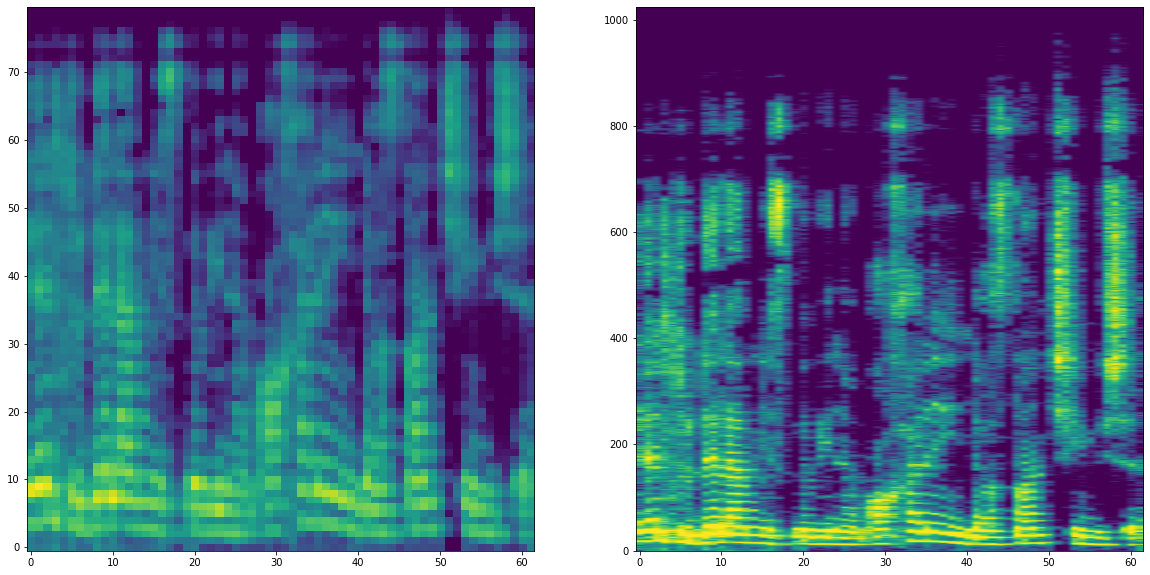

In [78]:
x, fs = librosa.load(df['path'][0], sr=22050)
x = audio_processor.trim_silence(x)
mel, spec = audio_processor(df['path'][0])
print(mel.shape, spec.shape)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(mel, aspect="auto", origin="lower")
plt.subplot(1,2,2)
plt.imshow(spec, aspect="auto", origin="lower")

In [79]:
y = audio_processor.spec_to_audio(spec)
y.shape

(62464,)

In [80]:
Audio(y, rate=22050)

In [102]:
import tacotron_tts.data
reload(tacotron_tts.data)
from tacotron_tts.data import TTSDataset, get_dataloader

dataset = TTSDataset('data/train.json', audio_processor, text_processor, div_steps=5, use_phonemes=False, precompute_feats=False)

[36, 12, 1, 22, 26, 24, 17, 19, 26, 7, 1, 33, 17, 20, 19, 24, 1, 17, 4, 19, 27, 17, 4, 21, 19, 33, 1, 17, 20, 22, 32, 24, 19, 22, 17, 30, 12, 17, 26, 17, 5, 22, 20, 8, 25, 19, 33, 17, 29, 20, 22, 26, 1, 17, 29, 8, 1, 19, 17, 22, 26, 17, 20, 22, 12, 17, 26, 17, 9, 33, 4, 17, 18, 34, 22, 17, 20, 21, 17, 22, 26, 8, 1, 21, 17, 20, 19, 35, 25, 37]
(191, 80) (191, 1025)


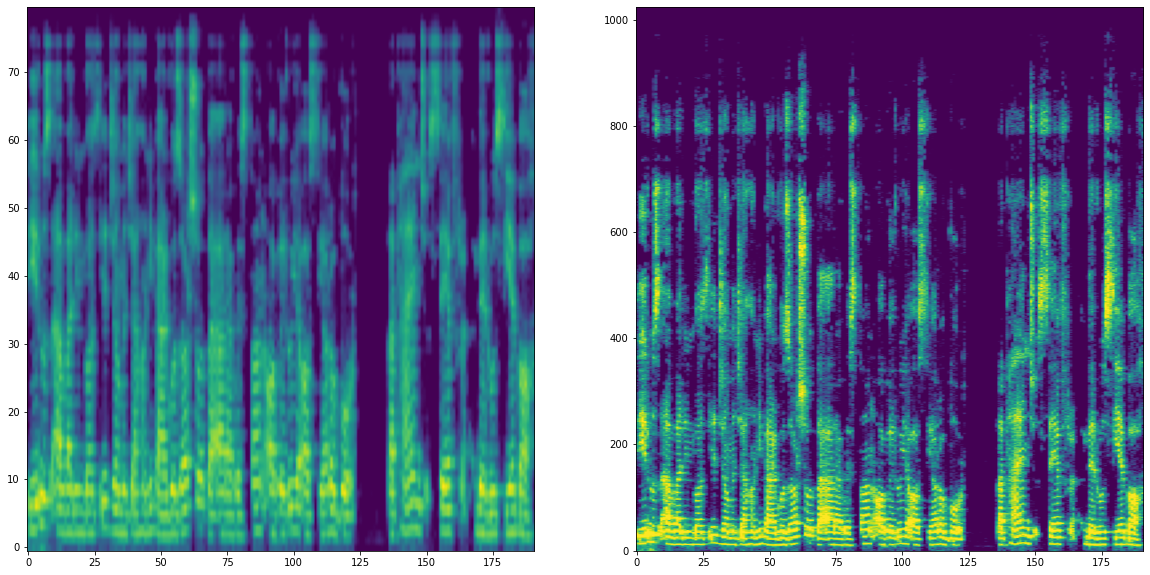

In [103]:
text, mel, spec = dataset[0]
print(text)
print(mel.shape, spec.shape)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(mel.T, aspect="auto", origin="lower")
plt.subplot(1,2,2)
plt.imshow(spec.T, aspect="auto", origin="lower")

In [104]:
tl = get_dataloader(dataset, batch_size=2, n_jobs=2)

In [105]:
b = next(iter(tl))
for a in b:
    print(a.shape)

torch.Size([2, 90])
torch.Size([2])
torch.Size([2, 195, 80])
torch.Size([2, 195, 1025])
